# Workshop 8. Наивный Байес и Классификация текстов

> Байесовские алгоритмы для классификации текстов  
> Извлечение признаков из текста

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Naive Bayes and Text Classification](https://sebastianraschka.com/Articles/2014_naive_bayes_1.html)
- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Байесовский классификатор](http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80)
- [Интересная статья про спам/не спам](https://habrahabr.ru/post/252265/)

Если вам понравилась задача распознавания текстов, то вот подборочка:

- [библиотека Gensim](https://radimrehurek.com/gensim/)
- [библиотека nltk](http://www.nltk.org/)
- [Лекция про word2vec 🔥](https://www.youtube.com/watch?v=oBb9aFmp0Hs)
- [Лекция Векторные представления слов и документов 🔥](https://www.youtube.com/watch?v=hiDBnEyoZS4)

## Наивный байесовский классификатор

На практике мы использовали его для детекции спам/не спам. В этот раз вы будете классифицировать [новостные тексты](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html). Попробуете разные методы  генерации признаков из текстов.

In [0]:
!git clone https://gitlab.7bits.it/isiganov/ml-course.git
  

Cloning into 'ml-course'...
remote: Enumerating objects: 397, done.
remote: Counting objects: 100% (397/397), done.
remote: Compressing objects: 100% (270/270), done.
remote: Total 397 (delta 129), reused 330 (delta 99)
Receiving objects: 100% (397/397), 52.17 MiB | 4.43 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### 2.1 Загрузка данных (2 балла)

Мы будем использовать только 4 класса текстов: `'alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics'`.

Загрузите тренировочную и тестовую части датасета для этих категорий.

In [0]:
newsgroups_test =  fetch_20newsgroups(subset='test', categories =[ 'alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics'],remove=('headers', 'footers', 'quotes'))
newsgroups_train =  fetch_20newsgroups(subset='train', categories =[ 'alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics'],remove=('headers', 'footers', 'quotes'))

In [0]:
newsgroups_test.target

array([2, 1, 1, ..., 3, 1, 1])

Выведите по 1 тексту для каждой из категории.

In [0]:
import numpy as np
import pandas as pd 
print(newsgroups_train.data[1])
print(newsgroups_test.data[1])




Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.
The Vatican library recently made a tour of the US.
 Can anyone help me in finding a FTP site where this collection is 
 available.



### 2.2 Мешок слов

Начнем с самого простого способа извлечения признаков из текстов: обычный подсчет количества употреблений слов в тексте.

Для этого используем [sklearn.feature_extraction.text.CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Настройте его так, чтобы он использовал англиские стоп слова.

Проведите трансформаци текстов из обоих датасетов и выведите размер полученного словаря. (1 векторайзер для тестового и тренировочного датасета! У вас должны получиться матрицы с одинаковыми признаками-словами)

In [0]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(newsgroups_train.data + newsgroups_test.data)
word_train = vectorizer.transform(newsgroups_train.data)
word_test =  vectorizer.transform(newsgroups_test.data)

In [0]:
len(newsgroups_train.data)

2034

In [0]:
len(newsgroups_test.data)

1353

In [0]:
word_test.shape, word_train.shape

((1353, 33529), (2034, 33529))

In [0]:
len(vectorizer.vocabulary_)

33529

In [0]:
newsgroups_test.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

Будем использовать классифиактор для мультиклассифкации [sklearn.naive_bayes.MultinomialNB]().

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [0]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB(alpha = 1.0,fit_prior =True )

In [0]:
model.fit(X = word_train,y= newsgroups_train.target)
cross_val_score(model, word_test,newsgroups_test.target,cv = 5 )

array([0.80514706, 0.84501845, 0.80442804, 0.81180812, 0.76865672])

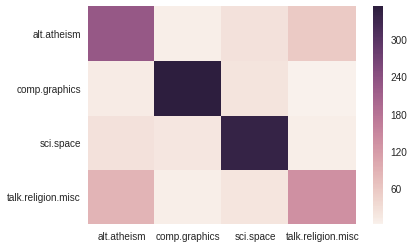

In [0]:
matrix =confusion_matrix(newsgroups_test.target, model.predict(word_test))

matrix =pd.DataFrame(matrix,columns = newsgroups_test.target_names,index=newsgroups_test.target_names )
sns.heatmap(matrix)


In [0]:
# Посмотрим на ТОП 10 по важности слова в каждой категории

def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: [%s]" % (category, " ".join(feature_names[top10])))

show_top10(model, vectorizer, newsgroups_train.target_names)

alt.atheism: [like believe say atheism does just think don people god]
comp.graphics: [software images files data use file jpeg edu graphics image]
sci.space: [just shuttle time orbit data like earth launch nasa space]
talk.religion.misc: [say know christian think just bible don jesus people god]


### 2.3 [Tf-IDF](https://ru.wikipedia.org/wiki/TF-IDF)

Мешок слов не учитывает "веса" слов, он просто смотрит их вхождение в документ. Вероятно, было бы полезно взвесить каким-то обраом каждое слово в документе. Действительно, если слово встречается во всех документах, то, наверное, его вес небольшой. А если редкое слово встречается в некоторых документах, то скорее всего оно какое-то узко тематическое.

Один из способов взвесить слова - это использовать меру tf-idf, где:

**TF - term frequency** - частота слова для каждой статьи

$$\LARGE \mathrm{tf}(t,d) = \frac{n_t}{\sum_k n_k}$$

**IDF - inverse document frequency*** — обратная частота документа - уменьшает вес часто встречаемых слов

$$\LARGE \mathrm{idf}(t, D) =  \log \frac{|D|}{|\{\,d_i \in D \mid t \in d_{i}\, \}|}$$

$D$ - число документов в корпусе

$|\{\,d_i \in D \mid t \in d_{i}\, \}|$ - число документов из коллекции ${\displaystyle D}$ , в которых встречается ${\displaystyle t}$  (когда ${\displaystyle n_{t}\neq 0}$ ).

**TF-IDF**

$$\LARGE \operatorname{tf-idf}(t,d,D) = \operatorname{tf}(t,d) \times \operatorname{idf}(t, D)$$


Для него есть класс [sklearn.feature_extraction.text.TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(newsgroups_train.data + newsgroups_test.data)
word_train = vectorizer.transform(newsgroups_train.data)
word_test =  vectorizer.transform(newsgroups_test.data)
model = MultinomialNB(alpha = 1.0,fit_prior =True )
model.fit(X = word_train,y= newsgroups_train.target)
cross_val_score(model, word_test,newsgroups_test.target,cv = 5 )


array([0.69117647, 0.74169742, 0.6900369 , 0.73431734, 0.70149254])

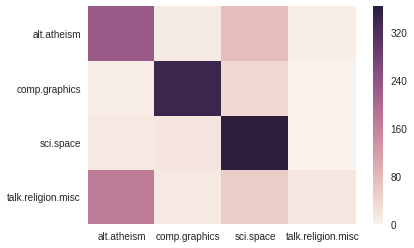

In [0]:
matrix =confusion_matrix(newsgroups_test.target, model.predict(word_test))
matrix=pd.DataFrame(matrix,columns = newsgroups_test.target_names,index=newsgroups_test.target_names )
sns.heatmap(matrix)

In [0]:
show_top10(model, vectorizer, newsgroups_train.target_names)

alt.atheism: [not in and it you is that of to the]
comp.graphics: [graphics you in it is for of and to the]
sci.space: [for that it space is in and of to the]
talk.religion.misc: [not it in you is and that to of the]


### 2.4 В чём проблема?

Как вы заметили, качество немного улучшилось. Как вы думаете почему у нас до сих пор есть ошибки? В чём проблема? Опирайтесь на вывод топа 10 важных слов, confusion matrix и репорт классификации.

**Задание**: Напишите развернутое рассуждение.

Ответ: ???

![](https://i.imgur.com/3D5pgrk.png)

Можно еще немного улучшить качество предсказания, если использовть n-граммы, то есть не только одиночные слова, но и пары, тройки. Для этого у векторайзера есть параметр `ngram_range`, но будьте осторожны, сгенерируется очень много признаков. Их количество можно ограничить  `max_features`. Ещё можно копать в сторону правильного процессинга текстов: лемматизация и стемминг, чтобы убирать окончания, но это обчно не сильно помогает в английском языке.

Кроме того можно было бы пойти совсем в другую сторону и использовать word-2-vec технологии, тогда бы у нас слова начал "обретать" смысл. Но это вовсем другая история.

In [0]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,5), max_df=0.7)
vectorizer.fit(newsgroups_train.data + newsgroups_test.data)
word_train = vectorizer.transform(newsgroups_train.data)
word_test =  vectorizer.transform(newsgroups_test.data)
model = MultinomialNB(alpha = 1.0,fit_prior =True )
model.fit(X = word_train,y= newsgroups_train.target)
cross_val_score(model, word_test,newsgroups_test.target,cv = 5 )

array([0.67279412, 0.64944649, 0.68265683, 0.66051661, 0.65671642])

In [0]:
array([0.67279412, 0.64944649, 0.68265683, 0.66051661, 0.65671642]) - 0.7

In [0]:
show_top10(model, vectorizer, newsgroups_train.target_names)


alt.atheism: [does deletion religion say atheism think just don people god]
comp.graphics: [hi use does program know file files image thanks graphics]
sci.space: [earth shuttle lunar just moon orbit launch like nasa space]
talk.religion.misc: [think objective just don christians bible christian people jesus god]
